# Set up environment

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 
from sklearn.feature_selection import RFE
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
import pandas.core.algorithms as algos
import numpy as np
import xgboost

In [16]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

# Import data and merge

In [17]:
dat = pd.read_csv('C:/Users/Jason.Vondersmith/Documents/GitHub/fraudmodel/kwikApps_gbmUpdates.csv', encoding = "ISO-8859-1", low_memory = False)
dlr = pd.read_csv('C:/Users/Jason.Vondersmith/Documents/GitHub/fraudmodel/kwikDealers.csv')
dat.columns = dat.columns.str.lower()
dlr.columns = dlr.columns.str.lower()
dat['entity_id'] = dat['entity_id'].str.lower()

In [18]:
fulldat = pd.merge(dat, dlr, on = 'entity_id', how = 'left')

In [19]:
fulldat[fulldat['fico'] > 8999]['fico'].value_counts()

9002    53
9003    30
9001     2
Name: fico, dtype: int64

In [20]:
##################################
#Convert columns to NAN where 0
###################################

fulldat['clarity_comb'] = fulldat['clarity_comb'].replace('0', np.nan)
fulldat['clarity_comb'] = fulldat['clarity_comb'].replace('(null)', np.nan)
fulldat['clarity_comb'] = fulldat['clarity_comb'].astype(float)
fulldat['fico'] = fulldat['fico'].replace('0', np.nan)
fulldat['fico'] = fulldat['fico'].replace('(null)', np.nan)
fulldat['fico'] = fulldat['fico'].replace(0, np.nan)
fulldat['fico'] = fulldat['fico'].replace(('9002', '9003', '9001'), np.nan)
fulldat['fico'] = fulldat['fico'].replace((9002, 9003, 9001), np.nan)
fulldat['datax'] = fulldat['datax'].replace('0', np.nan)
fulldat['datax'] = fulldat['datax'].replace('(null)', np.nan)
fulldat['datax'] = fulldat['datax'].replace(0, np.nan)
fulldat['factor_trust'] = fulldat['factor_trust'].replace('0', np.nan)
fulldat['factor_trust'] = fulldat['factor_trust'].replace('(null)', np.nan)
fulldat['factor_trust'] = fulldat['factor_trust'].replace(0, np.nan)
fulldat['clear_fraud'] = fulldat['clear_fraud'].replace('0', np.nan)
fulldat['clear_fraud'] = fulldat['clear_fraud'].replace('(null)', np.nan)
fulldat['clear_fraud'] = fulldat['clear_fraud'].replace(0, np.nan)

In [21]:
#######################################
# Replace NA's with Mean of Column
#######################################

fulldat['fico'].fillna(value = fulldat['fico'].mean(), inplace = True)
fulldat['clarity_comb'].fillna(value = fulldat['clarity_comb'].mean(), inplace = True)
fulldat['datax'].fillna(value = fulldat['datax'].mean(), inplace = True)
fulldat['factor_trust'].fillna(value = fulldat['factor_trust'].mean(), inplace = True)
fulldat['clear_fraud'].fillna(value = fulldat['clear_fraud'].mean(), inplace = True)
fulldat['monthly_income'].fillna(value = fulldat['monthly_income'].mean(), inplace = True)

In [22]:
fulldat[fulldat['fraud1'] == 1]['entity_id'].count()

1175

In [23]:
fulldat[fulldat['fraud1'] == 0]['entity_id'].count()

50017

In [24]:
cumutil = pd.read_csv('C:/Users/Jason.Vondersmith/Documents/GitHub/fraudmodel/cumUtil.csv')

In [25]:
cumutil.columns = cumutil.columns.str.lower()
cumutil['application_date'] = pd.to_datetime(cumutil['application_date'])

#get rid of people not approved.
data = cumutil.loc[(cumutil['approved_amount']!=0)].reset_index(drop=True)

#set up a blank dataframe for your output
data2 = pd.DataFrame()

#first for loop isolates each dealer and sorts by application date
for iter1 in data['entity_id'].unique():

    holding = data.loc[data['entity_id']==iter1]
    holding2 = holding.sort_values('application_date',ascending=True).reset_index(drop=True)
    #calculates utilization at each point in time
    for iter2 in range(0,len(holding2)):
        #use loc v. iloc because you need to isolate the first iteration
        holding3 = holding2.loc[0:iter2,:].reset_index(drop=True)
        #set the value of the holding frame at a particular iteration of the loop
        holding2.set_value(iter2,'cumulative_utilization',(holding3['funded_amount'].sum())/(holding3['approved_amount'].sum()))
        holding2.set_value(iter2, 'numapps', holding3['custid'].count())
    #appending it all together.
    data2 = data2.append([holding2],ignore_index=True)
    
#making your output pretty
data2 = data2.reset_index(drop=True)

In [26]:
dlrcumutil = data2.loc[:, ['custid', 'numapps', 'cumulative_utilization']]

In [27]:
fulldat = pd.merge(fulldat, dlrcumutil, on = 'custid', how = 'left')

In [28]:
###### Drop all Apps w/o an approved amount
fulldat = fulldat[~fulldat['cumulative_utilization'].isnull()]

In [29]:
cols = fulldat.columns.tolist()
cols = cols[:-5] + [cols[-1]] + [cols[-2]] + [cols[-3]] + [cols[-4]]  + [cols[-5]] 
fulldat = fulldat[cols]

In [30]:
fulldat.head()

application_date application_time  app_status  entity_id  location_id  \
0       10/28/2014         11:35:25  CLOSED      cavaliere            1   
1       10/30/2014          9:39:26  CLOSED      cavaliere            1   
2       10/30/2014          9:40:11  CLOSED      cavaliere            1   
3       12/20/2014         15:31:44  FUNDED      cavaliere            1   
5        11/7/2014         17:37:56  APPROVED    cavaliere            1   

     user_id  cust  acct  custid first_name    ...        bin ssns_w_bank  \
0  Cavaliere     2     1   1-2-1      Julie    ...        NaN           0   
1  Cavaliere     4     1   1-4-1    michele    ...        NaN           0   
2  Cavaliere     5     1   1-5-1    crystal    ...     436802           0   
3  Cavaliere     8     1   1-8-1      Carla    ...        NaN           1   
5  Cavaliere    14     1  1-14-1    Kendria    ...     449590           1   

  add_num_bank idv bav cumulative_utilization  numapps fraud2  fraud1  \
0            0   0   0               0.144000      1.0    0.0     0.0   
1            0   0   0               0.355998      2.0    0.0     0.0   
2            0   0   0               0.395808      3.0    0.0     0.0   
3            2   0   0               0.486435     16.0    0.0     0.0   
5            0  A1  A2               0.301910      4.0    0.0     0.0   

   achdebit  
0         0  
1         0  
2         0  
3         0  
5         0  

[5 rows x 57 columns]

## Create Features

In [31]:
modeldat = fulldat.copy(deep=True)

In [32]:
def f(row):
    a = str(row['routing'])[:2]
    return a

modeldat['f2rout'] = modeldat.apply(f, axis = 1)

In [33]:
def g(row):
    a = str(row['zip'])[:2]
    return a

modeldat['zipzone'] = modeldat.apply(g, axis = 1)

## Split Independent/Dependent variables and use RFE to select features

In [34]:
cols

['application_date',
 'application_time',
 'app_status',
 'entity_id',
 'location_id',
 'user_id',
 'cust',
 'acct',
 'custid',
 'first_name',
 'middle_initial',
 'last_name',
 'address',
 'address_2',
 'city',
 'state',
 'zip',
 'homeowner',
 'home_phone',
 'home_ext',
 'work_phone',
 'cellphone',
 'email',
 'id_number',
 'id_state',
 'bank',
 'routing',
 'cc_expiration',
 'payment_frequency',
 'payments',
 'direct_deposit',
 'employer',
 'hire_date',
 'job_title',
 'monthly_income',
 'reference_name1',
 'reference_phone1',
 'reference_relationship1',
 'reference_name2',
 'reference_phone2',
 'reference_relationship2',
 'datax',
 'clarity_comb',
 'factor_trust',
 'fico',
 'clear_fraud',
 'approved_amount',
 'bin',
 'ssns_w_bank',
 'add_num_bank',
 'idv',
 'bav',
 'cumulative_utilization',
 'numapps',
 'fraud2',
 'fraud1',
 'achdebit']

In [35]:
cols = modeldat.columns.tolist()
ind = ['state','homeowner', 'monthly_income', 'bin','ssns_w_bank',  'add_num_bank', 'idv','bav', 'cumutilnorm', 'numapps', 'f2rout', 'zipzone']
#modeldat = modeldat[ind]

### Split data into test/training and build model

In [562]:
#x_train_full, x_val_full, y_train_full, y_val_full = train_test_split(X, y,
 #                                                 test_size = .3,
   #                                               random_state=12)

In [36]:
X = modeldat[['fico', 'monthly_income', 'cumulative_utilization']].reset_index(drop = True)
y = modeldat['fraud1'].reset_index(drop = True)

In [37]:
X

fico  monthly_income  cumulative_utilization
0      557.938836     4198.724344                0.144000
1      557.938836     4198.724344                0.355998
2      557.938836     2300.000000                0.395808
3      557.938836     4198.724344                0.486435
4      557.938836     2600.000000                0.301910
5      592.000000     4198.724344                0.435764
6      557.938836     2400.000000                0.000000
7      557.938836     1600.000000                0.000000
8      557.938836     4198.724344                0.400575
9      557.938836     6814.000000                0.000000
10     557.938836     2000.000000                0.000000
11     557.938836     4000.000000                0.442314
12     557.938836     2280.000000                0.000000
13     544.000000     4198.724344                0.463837
14     557.938836     2000.000000                0.000000
15     557.938836     5600.000000                0.000000
16     614.000000     4198.724344                0.462309
17     594.000000     4198.724344                0.493839
18     557.938836     3200.000000                0.445304
19     557.938836     2400.000000                0.000000
20     557.938836     4198.724344                0.600000
21     557.938836     2800.000000                0.478359
22     579.000000     4198.724344                0.331104
23     562.000000     4198.724344                1.000000
24     519.000000     4198.724344                0.512024
25     557.938836     1200.000000                0.499524
26     557.938836     2500.000000                0.474547
27     557.938836     4198.724344                0.543945
28     605.000000     4198.724344                0.423993
29     557.938836     9600.000000                0.635181
...           ...             ...                     ...
34151  659.000000     2400.000000                0.000000
34152  582.000000     9886.000000                0.211697
34153  573.000000     3000.000000                0.399683
34154  533.000000     2600.000000                0.578950
34155  539.000000     5300.000000                0.583864
34156  539.000000     5300.000000                0.571690
34157  617.000000     2400.000000                0.063015
34158  524.000000     6800.000000                0.564626
34159  516.000000     3958.000000                0.487452
34160  584.000000     9000.000000                0.395866
34161  494.000000     1000.000000                0.364921
34162  495.000000     3234.000000                0.117216
34163  559.000000     1800.000000                0.000000
34164  491.000000     1000.000000                0.298905
34165  556.000000     5500.000000                0.000000
34166  556.000000     5500.000000                0.000000
34167  542.000000     5000.000000                0.392864
34168  558.000000     3200.000000                0.433605
34169  647.000000     1700.000000                0.641919
34170  552.000000     1200.000000                0.453845
34171  521.000000     4000.000000                0.412930
34172  466.000000     6000.000000                0.522692
34173  518.000000     3600.000000                0.235118
34174  584.000000     2200.000000                0.585886
34175  605.000000     2700.000000                0.411843
34176  477.000000     6000.000000                0.542084
34177  557.938836     1470.000000                0.403148
34178  688.000000     6250.000000                0.407573
34179  579.000000     2700.000000                0.523217
34180  634.000000     5200.000000                0.403852

[34181 rows x 3 columns]

In [38]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [576]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [568]:

# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

TypeError: unhashable type: 'slice'

In [583]:
len(X)

34181

In [39]:
num_examples = len(X) # training set size
nn_input_dim = 3 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

In [40]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [41]:

# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1)
    return np.argmax(probs, axis=1)

In [42]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((X.shape[0], nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((X.shape[0], nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

In [591]:
np.sum?

In [43]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, X))
plt.title("Decision Boundary for hidden layer size 3")

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [412]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(x_train_res_full, y_train_res_full)
print("Accuracy on training set: {:.3f}".format(rf.score(x_train_res_full, y_train_res_full)))
print("Accuracy on test set: {:.3f}".format(rf.score(x_val_full, y_val_full)))

Accuracy on training set: 1.000
Accuracy on test set: 0.991


In [436]:
al_data = fulldat.copy(deep=True)

In [438]:
al_data['prob'] = mod.predict_proba(fulldat.loc[:,var])[:,1]
al_data['pred_fraud'] = mod.predict(fulldat.loc[:,var])

In [439]:
al_data

cumulative_utilization            entity_id  dlrutil  ssns_w_bank  \
0                    0.301910            cavaliere     0.58            1   
2                    0.435764            cavaliere     0.58            1   
3                    0.000000          52_atlantic     0.61            1   
5                    0.000000  vamattresswholesale     0.00            1   
6                    0.442314            cavaliere     0.58            1   
7                    0.463837            cavaliere     0.58            1   
8                    0.000000  vamattresswholesale     0.00            1   
10                   0.000000                mzone     0.54            1   
11                   0.000000          52_atlantic     0.61            1   
14                   0.478359            cavaliere     0.58            1   
15                   0.331104          52_atlantic     0.61            1   
16                   1.000000                  mfd     0.38            1   
17                   0.512024            cavaliere     0.58            1   
19                   0.499524            cavaliere     0.58            1   
21                   0.474547            cavaliere     0.58            1   
25                   0.635181              fraleys     0.73            1   
26                   0.460848              fraleys     0.73            2   
27                   0.350676              fraleys     0.73            1   
30                   0.508938            cavaliere     0.58            1   
31                   0.473991            cavaliere     0.58            1   
32                   0.463197            cavaliere     0.58            1   
34                   0.416630            cavaliere     0.58            1   
35                   0.426243            cavaliere     0.58            1   
36                   0.484070            cavaliere     0.58            1   
37                   0.453273            cavaliere     0.58            1   
38                   0.454696            cavaliere     0.58            1   
40                   0.507806            cavaliere     0.58            1   
41                   0.458863            cavaliere     0.58            1   
42                   0.533506              roberts     0.59            1   
44                   0.480896            cavaliere     0.58            1   
...                       ...                  ...      ...          ...   
39376                0.406710   americanmattressil     0.39            1   
39377                0.453843         mbahenderson     0.45            1   
39382                0.631206     mbasouthatljones     0.63            1   
39385                0.522920     mattressmattress     0.52            1   
39386                0.484848            mbaeasley     0.48            1   
39387                0.403936   americanmattressil     0.39            1   
39390                0.625000       uniquehomefurn     0.63            1   
39391                0.368291        mbagouverneur     0.37            1   
39392                0.574002         partnersfurn     0.57            1   
39396                0.558077          mbaleesburg     0.56            1   
39398                0.751878              dcibeds     0.52            1   
39402                0.402758   americanmattressil     0.39            2   
39404                0.000000          furnfactory     0.00            1   
39406                0.211697          qualityfurn     0.21            1   
39407                0.399683   americanmattressil     0.39            1   
39408                0.578950         mbalancaster     0.58            1   
39410                0.583864            maxxdrive     0.56            1   
39411                0.571690            maxxdrive     0.56            1   
39414                0.564626            maxxdrive     0.56            1   
39415                0.487452            mbasummit     0.49            1   
39417                0.395866   americanmattressil     

In [440]:
a = al_data.loc[:, ['FRAUD1', 'prob', 'pred_fraud']]
a.to_csv('fmod2.csv')

# breakdown of 42 for Rob

In [441]:
dat = al_data.copy(deep=True)

#dat['prob'] = mod.predict_proba(dat.loc[:,rfevar])[:,1]

#dat['pred_fraud'] = mod.predict(dat.loc[:,rfevar])

In [118]:
dat.head()

ENTITY_ID  dlrUtil  ssns_w_bank  ssn_num_cell  add_num_bank  \
37345          joetahans     0.45            1             0             1   
21028  stunningfurniture     0.59            1             0             0   
804      abffayetteville     0.64            1             0             2   
13957       abfnashville     0.66            1             0             1   
22955    abffayetteville     0.64            1             0             2   

        HIRE_DATE     custID  FICO APPLICATION_DATE APPLICATION_TIME  \
37345    6/1/2016  1-46339-1   506        6/28/2017         13:19:05   
21028         NaN  1-24762-1   564        2/24/2017         20:34:36   
804    10/11/2011    1-835-1   536        5/18/2015         18:08:53   
13957         NaN  1-16428-1   524       11/19/2016         18:17:47   
22955    1/5/2004  1-27020-1   534         3/6/2017         17:04:22   

          ...      abv2ssn_num_cell  0add_num_bank  1add_num_bank  \
37345     ...                     0              0              1   
21028     ...                     0              1              0   
804       ...                     0              0              0   
13957     ...                     0              0              1   
22955     ...                     0              0              0   

       2add_num_bank  abv2add_num_bank  dlrUtilnorm  FRAUD1  FRAUD2      prob  \
37345              0                 0        -1.05       0       0  0.410922   
21028              0                 0         0.14       0       0  0.410922   
804                1                 0         0.55       0       0  0.410922   
13957              0                 0         0.75       0       0  0.443755   
22955              1                 0         0.55       0       0  0.410922   

       pred_fraud  
37345           0  
21028           0  
804             0  
13957           0  
22955           0  

[5 rows x 75 columns]

In [443]:
for i in list(dat[dat['fraud1'] == 1]['entity_id'].unique()):
    print(i)
    print('Cases of Fraud:{j}'.format(j = dat[(dat['fraud1'] == 1) & (dat['entity_id'] == i)]['entity_id'].count()))
    ff = dat[(dat['pred_fraud'] == 1) & (dat['fraud1'] == 1) & (dat['entity_id'] == i)]['entity_id'].count()
    fnf = dat[(dat['pred_fraud'] == 0) & (dat['fraud1'] == 1) & (dat['entity_id'] == i)]['entity_id'].count()
    print(ff,fnf)


varietydiscount
Cases of Fraud:54
39 15
homelinen
Cases of Fraud:25
25 0
otromundo
Cases of Fraud:21
5 16
globalcomp
Cases of Fraud:69
59 10
ajsrugsandfurn
Cases of Fraud:22
5 17
chitownfurnlinen
Cases of Fraud:9
9 0
buybetter
Cases of Fraud:15
15 0
goldenmatt
Cases of Fraud:15
13 2
queencityfurn
Cases of Fraud:10
10 0
discountfurniture
Cases of Fraud:9
9 0
valuezonefandm
Cases of Fraud:19
19 0
diamondloungefurn
Cases of Fraud:11
11 0
lincolnfurn
Cases of Fraud:11
11 0
crownfurn
Cases of Fraud:7
7 0


In [444]:
for i in list(dat[dat['fraud1'] == 1]['entity_id'].unique()):
    print(i)
    print(dat[(dat['pred_fraud'] == 1) & (dat['fraud1'] == 1) & (dat['entity_id'] == i)]['custid'])

varietydiscount
18218    1-21521-1
18457    1-21786-1
18463    1-21792-1
18676    1-22045-1
18905    1-22299-1
18943    1-22343-1
19358    1-22854-1
19389    1-22891-1
20101    1-23706-1
21029    1-24763-1
21061    1-24804-1
21444    1-25246-1
21774    1-25629-1
21817    1-25683-1
22036    1-25961-1
22226    1-26174-1
22252    1-26203-1
22327    1-26284-1
22466    1-26445-1
22975    1-27043-1
22977    1-27043-2
23061    1-27143-1
23075    1-27161-1
23159    1-27261-1
23180    1-27283-1
23307    1-27435-1
23410    1-27555-1
23629    1-27794-1
23679    1-27850-1
23986    1-28191-1
24025    1-28237-1
24408    1-28668-1
24626    1-28931-1
24729    1-29050-1
25620    1-30098-1
25670    1-30158-1
26550    1-31225-1
26614    1-31295-1
28513    1-33593-1
Name: custid, dtype: object
homelinen
20736    1-24436-1
20937    1-24657-1
21557    1-25376-1
23963    1-28165-1
25944    1-30502-1
28461    1-33532-1
28587    1-33679-1
29554    1-34897-1
29892    1-35571-1
30043    1-35843-1
30226    1-3617

In [16]:
#Try again with 10 Features
logreg = LogisticRegression()
rfe = RFE(logreg, 10)
rfe = rfe.fit(x_train_res_full, y_train_res_full)

In [17]:
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), var)))

[(1, 'abv95util'), (1, 'bavA'), (1, 'bavD'), (1, 'ccExp90'), (1, 'ddB'), (1, 'hire60'), (1, 'idvD'), (1, 'pfunknown'), (1, 'util89'), (1, 'util95'), (2, 'ccExp60'), (3, 'ccExp180'), (4, 'und50Util'), (5, 'dlrUtilnorm'), (6, 'mi34'), (7, 'mi5000'), (8, 'mi45'), (9, 'mi23'), (10, 'homeownR'), (11, 'homeownO'), (12, 'homeownT'), (13, 'ccExp360'), (14, 'ccExp361'), (15, 'idvA'), (16, 'util58'), (17, 'hire361'), (18, 'mi2000'), (19, '2ssn_num_cell'), (20, 'hire360'), (21, '0ssn_num_cell'), (22, 'CLEAR_FRAUD'), (23, 'CLARITY'), (24, 'pfsemimonthly'), (25, 'abv2add_num_bank'), (26, '1add_num_bank'), (27, '2add_num_bank'), (28, 'ddY'), (29, 'hire30'), (30, '2ssns_w_bank'), (31, 'hire90'), (32, '1ssns_w_bank'), (33, 'ppBin'), (34, '0ssns_w_bank'), (35, 'abv2ssns_w_bank'), (36, 'achdebit_att90'), (37, 'DX'), (38, '0add_num_bank'), (39, 'abv2ssn_num_cell'), (40, 'pfbiweekly'), (41, 'pfmonthly'), (42, 'fico'), (43, 'hire180'), (44, '1ssn_num_cell')]


In [18]:
rfeten = ['abv95util', 'bavA', 'bavD', 'ccExp90', 'ddB', 'hire60', 'idvD', 'pfunknown', 'util89', 'util95']
tenX=fulldat[rfeten]
tenY=fulldat['FRAUD1'] 

Original dataset shape Counter({0: 38997, 1: 456})
Resampled dataset shape Counter({0: 35093, 1: 35093})
Accuracy of logistic regression classifier on test set: 0.98


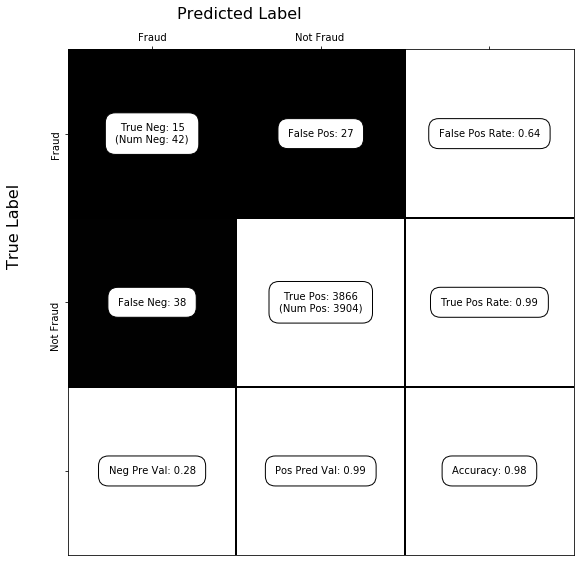

In [20]:
logreg = LogisticRegression()

x_train_ten, x_val_ten, y_train_ten, y_val_ten = train_test_split(tenX, tenY,
                                                  test_size = .1,
                                                  random_state=12)

sm = SMOTE(random_state=12)
x_train_res_ten, y_train_res_ten = sm.fit_sample(x_train_ten, y_train_ten)
print('Original dataset shape {}'.format(Counter(tenY)))
print('Resampled dataset shape {}'.format(Counter(y_train_res_ten)))

logreg.fit(x_train_res_ten,y_train_res_ten)
y_predct_ten = logreg.predict(x_val_ten)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_val_ten, y_val_ten)))
cm = confusion_matrix(y_val_ten, y_predct_ten, labels = [1,0])
show_confusion_matrix(cm, ['Fraud', 'Not Fraud '])

# Deprecated

In [66]:
#Use Full data set - 92% - 8% non fraud

X=fulldat[var]
y=fulldat['FRAUD1']

#Use a data set that is 50% fraud

halfdat = fulldat[fulldat['FRAUD1'] == 0].sample(500)
fdat = fulldat[fulldat['FRAUD1'] == 1]
halfdat = halfdat.reset_index(drop = True)
fdat = fdat.reset_index(drop = True)

halfdat = pd.concat([halfdat, fdat], ignore_index = True)

halfX = halfdat[var]
halfy = halfdat['FRAUD1']

#SMOTE - synthetically create more fraud cases to build model


print('Original dataset shape {}'.format(Counter(y)))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 38997, 1: 456})
Resampled dataset shape Counter({0: 38997, 1: 38997})


In [67]:
#Use RFE (recursive feature engineering to select variables for the model)


logreg = LogisticRegression()
rfe = RFE(logreg, 5)
rfe = rfe.fit(X_res, y_res)
#print(rfe.support_)
#print(rfe.ranking_)
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), var)))

[(1, 'bavD'), (1, 'ddB'), (1, 'hire60'), (1, 'util89'), (1, 'util95'), (2, 'idvD'), (3, 'bavA'), (4, 'abv95util'), (5, 'ccExp90'), (6, 'pfunknown'), (7, 'ccExp60'), (8, 'ccExp180'), (9, 'und50Util'), (10, 'dlrUtilnorm'), (11, 'mi5000'), (12, 'mi34'), (13, 'mi45'), (14, 'mi23'), (15, 'homeownR'), (16, 'homeownO'), (17, 'homeownT'), (18, 'ccExp360'), (19, 'idvA'), (20, 'util58'), (21, 'hire361'), (22, 'ccExp361'), (23, 'mi2000'), (24, 'hire30'), (25, 'ddY'), (26, 'hire360'), (27, 'CLEAR_FRAUD'), (28, '2ssn_num_cell'), (29, '0ssn_num_cell'), (30, 'CLARITY'), (31, '2add_num_bank'), (32, '1add_num_bank'), (33, 'hire90'), (34, 'abv2add_num_bank'), (35, 'pfsemimonthly'), (36, '2ssns_w_bank'), (37, '1ssns_w_bank'), (38, 'abv2ssns_w_bank'), (39, 'ppBin'), (40, '0ssns_w_bank'), (41, 'hire180'), (42, 'abv2ssn_num_cell'), (43, 'pfbiweekly'), (44, 'achdebit_att90'), (45, 'DX'), (46, 'pfmonthly'), (47, '0add_num_bank'), (48, '1ssn_num_cell'), (49, 'fico')]


In [68]:
rfevar = ['abv95util', 'bavD', 'und50Util', 'util58', 'util89', 'util95', 'idvA', 'idvD', 'bavA']
rfevar2 = ['abv95util', 'bavD', 'idvD', 'und50Util', 'util58', 'util89', 'util95', 'idvA', 'idvD', 'bavA', 'hire60', 'hire30', 'hire90', 'hire180', 'hire360', 'hire361', 'ddB', 'ddY']
X_res = fulldat[rfevar]
y_res = fulldat['FRAUD1']

halfX = halfdat[rfevar]
halfy = halfdat['FRAUD1']

In [42]:
#If one variable is identified as significant, change data to yes/no for that variable.
# i.e. hire60 is one of 5 - lump others together to be binary.  Same with util89 and util 95

dat3 = pd.read_csv('C:/Users/Jason.Vondersmith/Documents/GitHub/fraudmodel/kwikApps_filt_3.csv')
dat3 = pd.merge(dat3, dlr, on = 'ENTITY_ID', how = 'left')
var3 = ['bavA', 'bavD', 'util89_bin', 'util95_bin', 'ddB_bin', 'hire60_bin']
X = dat3[var3]
y = dat3['FRAUD1']
 
print('Original dataset shape {}'.format(Counter(y)))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 38997, 1: 456})
Resampled dataset shape Counter({0: 38997, 1: 38997})


In [69]:
result = logreg.fit(X_res,y_res)

In [27]:
X_res.iloc[5000,:]

abv95util    0
bavD         1
idvD         0
und50Util    0
util58       1
util89       0
util95       0
idvA         1
idvD         0
bavA         0
hire60       0
hire30       0
hire90       0
hire180      0
hire360      0
hire361      1
ddB          0
ddY          1
Name: 5000, dtype: int64

In [30]:
result([0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1])

TypeError: 'LogisticRegression' object is not callable

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [80]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.99


In [81]:

kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.989


[[   11   131]
 [   10 11684]]


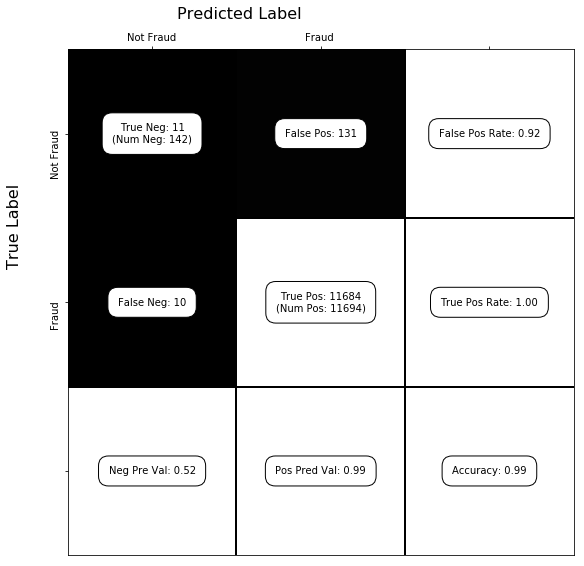

In [82]:

confusion_matrix = confusion_matrix(y_test, y_pred, labels = [1,0])
print(confusion_matrix)
show_confusion_matrix(confusion_matrix, ['Not Fraud', 'Fraud '])

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

NameError: name 'y_test' is not defined

In [85]:

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     11694
          1       0.52      0.08      0.13       142

avg / total       0.98      0.99      0.98     11836

